In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from jupyterthemes import jtplot
jtplot.style()

import Functions as fun

Let's plot the map again (from last notebook) and the first emitters line in our irrigation system:

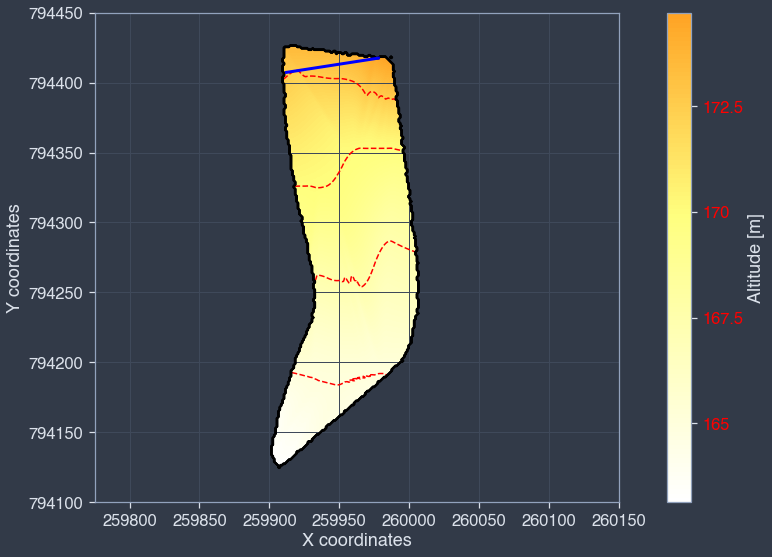

In [2]:
fun.plot_map()
# A 66 meters row in the top of the map according to govmap
line_0 = np.array([[259912.2193, 794407.3171],
                   [259977.9211, 794417.5103]]) 
plt.plot(line_0[:,0],line_0[:,1],lw=3,c='blue')

## Calculating a Line Bellow

Next, we define a function that calculates the two points of a new line that its distance from a line ('line' argument) is r ('r' as argument) row. Note that each row is 6 meters.

Note the we want the line will be in the following way. The distance vector from the starting point on the new line is perpendicular to the 'line' vector (You can see the next figure in order to understand the idea).

The function is according to:


Let's call to the first two points of 'line' argument $P_0 = (x_1, y_1)$ and $P_1 = (x_2, y_2)$

Let's consider
* $(a,b)$ the starting point (from the west) of the next line bellow 'line'
* $m = \frac{y_2 - y_1}{x_2 - x_1}$ the coordinate slope of 'line'
* $D$, the row distance, in our case is 6 meters.

There are two conditions for $(a,b)$:
* $\frac{y_1 - b}{x_1 - a} = - \frac{1}{m}$
* $(y_1 - b)^2 + (x_1 - a)^2 = D^2$

The solution is:

$b = \pm y_1 - \sqrt{\frac{D^2}{1+m^2}}$

$a = x_1 - m(b-y_1)$

And to calculate the end point of the line that starts are $(a,b)$, we can do the same thing only this time using $P_1 = (x_2, y_2)$.

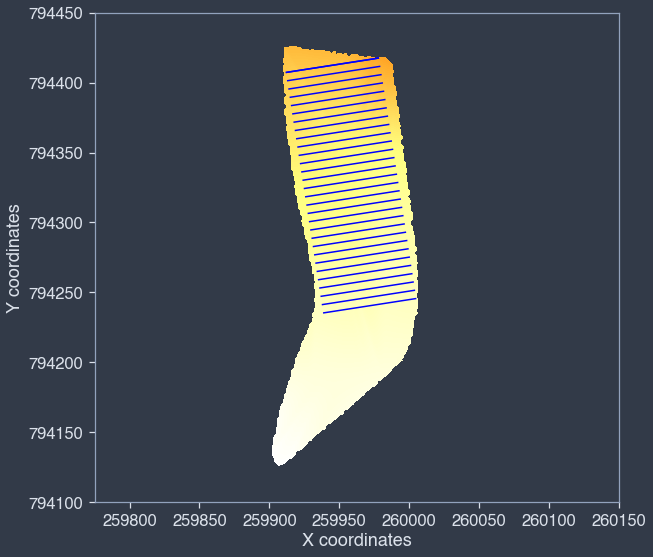

In [3]:
def calculate_distance(line):
    return np.sqrt(np.sum((line[1] - line[0]) ** 2))

def calculate_coor_slope(line):
    return (line[1][1] - line[0][1])/(line[1][0] - line[0][0])

def calculate_line_point_from(r,line):
    result = np.array([])
    for i in [0,1]:
        x1 = line[i][0]
        y1 = line[i][1]
        D = 6 * r
        m = calculate_coor_slope(line_0)
        b = y1 - np.sqrt(D ** 2 / (1 + m ** 2))
        a = x1 - m * (b - y1)
        result = np.append(result, np.array([a,b]))
    return result.reshape(2,2)

fun.plot_map(False,False)
line_0 = np.array([[259912.2193, 794407.3171],
                   [259977.9211, 794417.5103]]) # A 66 meters row in the top of the map
plt.plot(line_0[:,0],line_0[:,1],c='blue')
plt.grid(b=False)

for r in np.arange(0,30,1):
    line_r = calculate_line_point_from(r,line_0)
    plt.plot(line_r[:,0],line_r[:,1],c='blue')

It's easy to see that after 30 rows we need to change the direction. After trials and errors we got the next lines that consists our irrigation emitters lines:

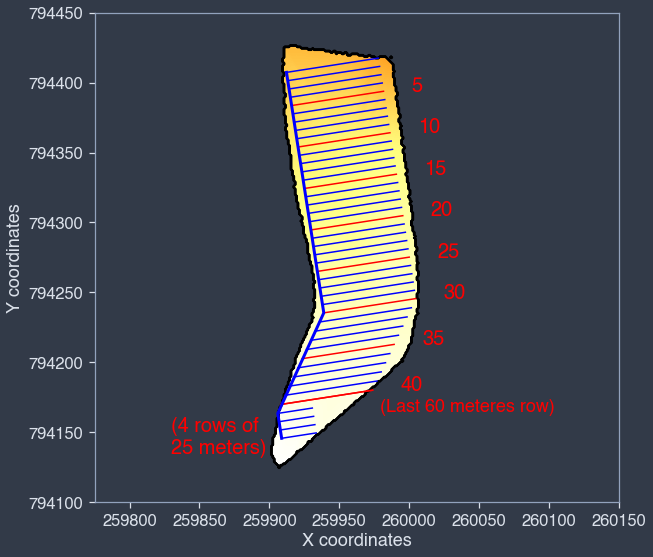

In [4]:
fun.plot_map(False,True)
plt.grid(b=False)
#plot_irr_area(irr_area_points)
m = calculate_coor_slope(line_0)
main_line = []
lines = []
for r in np.arange(0,40,1):
    line = calculate_line_point_from(r,line_0) # 30 rows max
    if r < 30:
        x_shift = 0
    if r >= 30 and r < 40:
        x_shift = (r-29) * 4
    y_shift = x_shift * m
    line = line - np.array([[x_shift,y_shift],[x_shift,y_shift]])
    if r == 39:
        plt.text(line[1,0]+5,line[1,1]-15,'(Last 60 meteres row)',c='red')
        plt.plot(line[:,0],line[:,1],c='red')
    if (r + 1) % 5 == 0: 
        plt.text(line[1,0]+20,line[1,1],str(r+1),c='red',fontsize=20)
        plt.plot(line[:,0],line[:,1],c='red')
    else:
        plt.plot(line[:,0],line[:,1],c='blue')
    if r in [0,29]:
        main_line.append(line[0])
    lines.append(line.flatten())
    
line_39 = lines[-1].reshape(2,2)
for r in np.arange(1,5,1):
    line = calculate_line_point_from(r,line_39)
    m = calculate_coor_slope(line_39)
    x_shift = 3
    y_shift = x_shift * m
    line = line - np.array([[x_shift,y_shift],[x_shift,y_shift]])
    line[1] = line[1] - np.array([[41,41*m]])
    plt.plot(line[:,0],line[:,1],c='blue')
    if r in [1,4]:
        main_line.append(line[0])
    lines.append(line.flatten())

plt.text(259830,794135,'(4 rows of\n25 meters)',c='red',fontsize=20)
main_line = np.array(main_line)
plt.plot(main_line[:,0],main_line[:,1],c='blue',lw=3)

plt.savefig('BlackThemeFigures/InitialIrrigationSystem')
np.save('LinesData/lines', lines)
np.save('LinesData/main_line', main_line)

Let's calculate the main line distance:

In [5]:
main_line_dis = 0
for i in range(0,len(main_line) - 1):
    main_line_dis = main_line_dis + calculate_distance(main_line[i:i+2])
main_line_dis

271.0538073270221

# Altitude Profile

Looks like that the topography isn't flat for the first rows, let's check it out:

<ipython-input-6-bd0aa9bdfb5a>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,4))


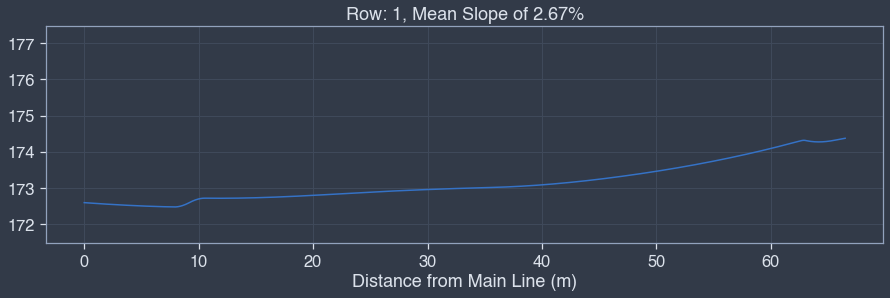

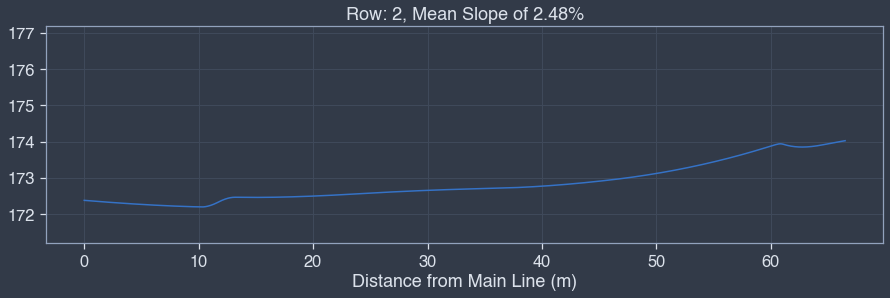

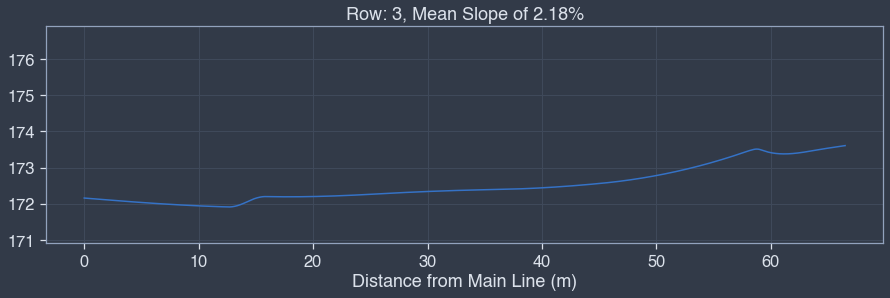

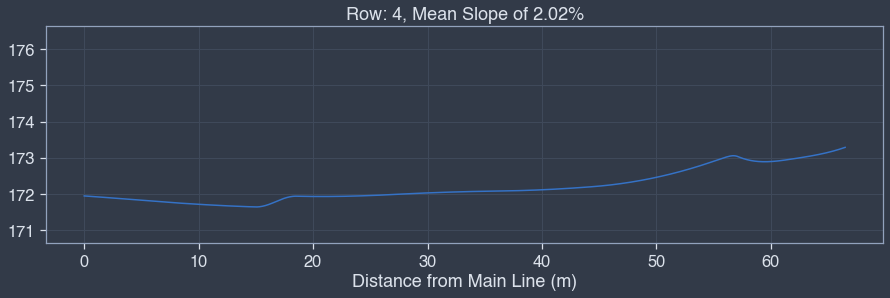

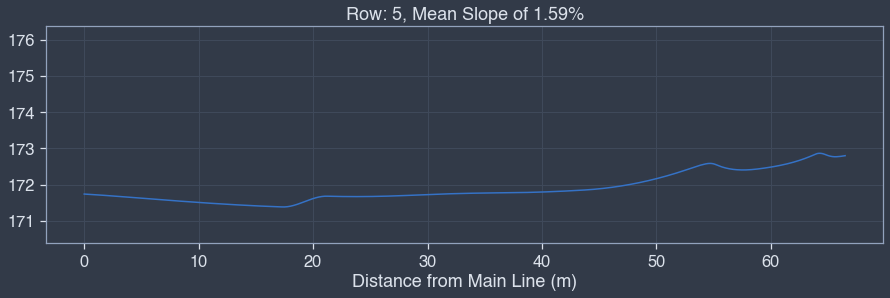

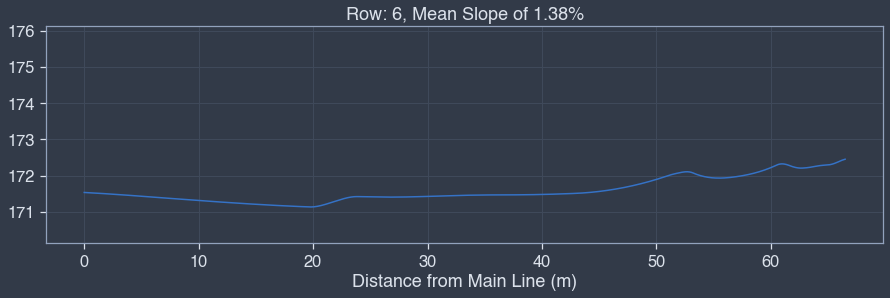

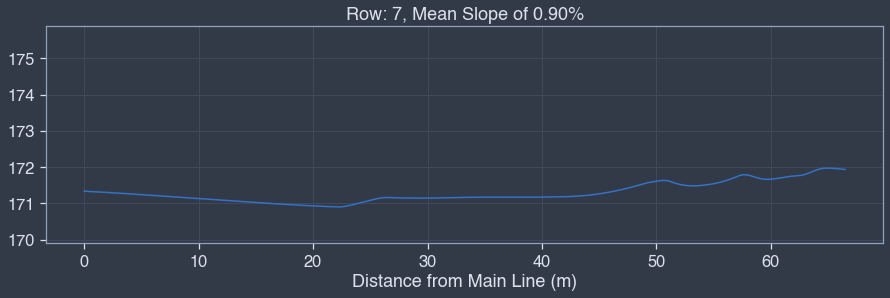

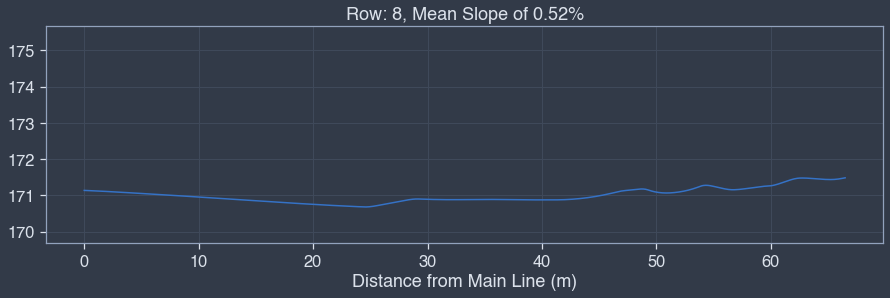

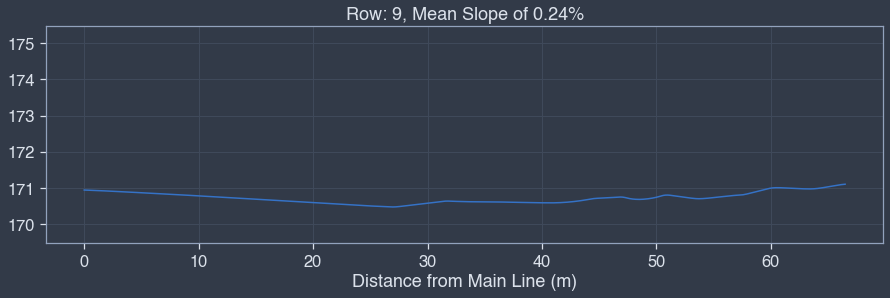

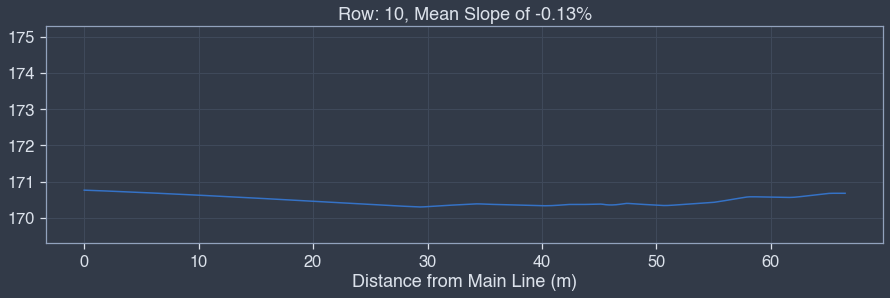

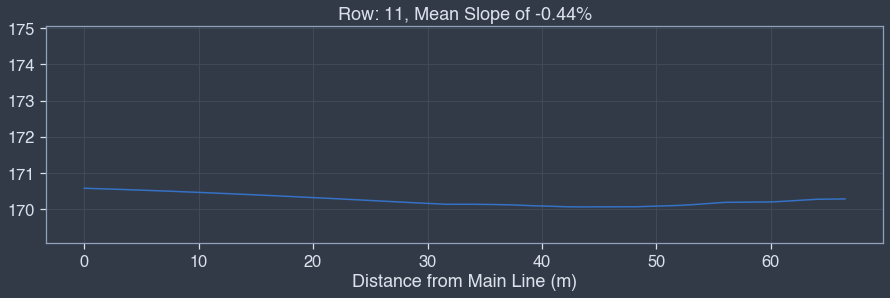

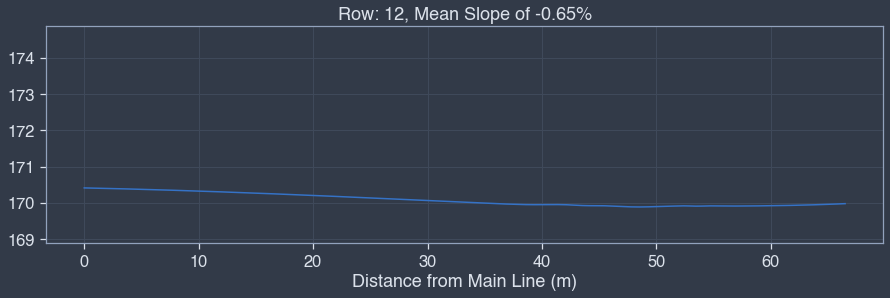

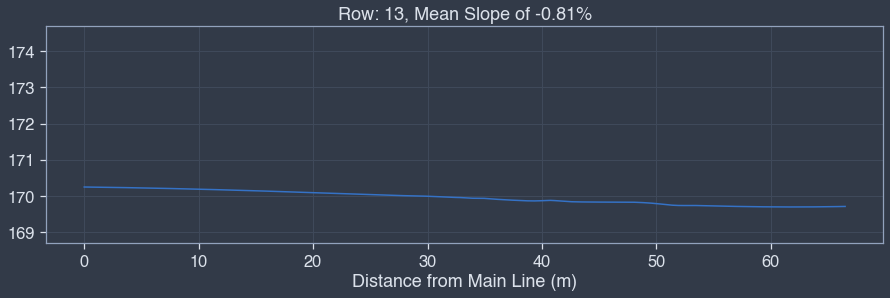

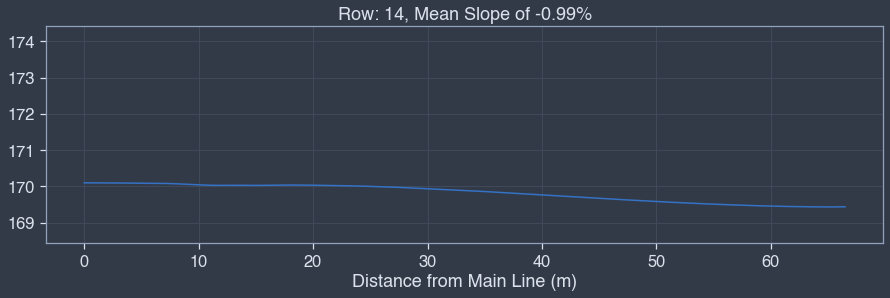

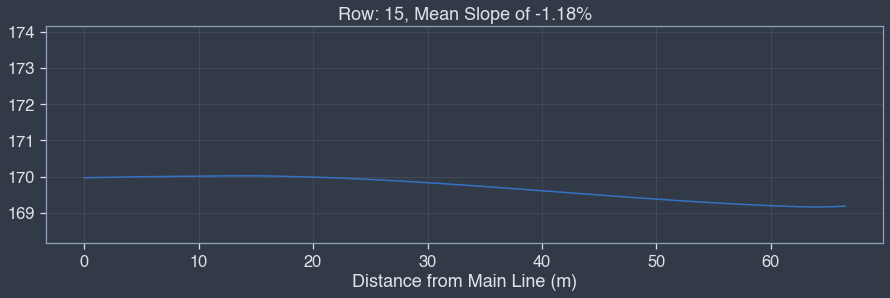

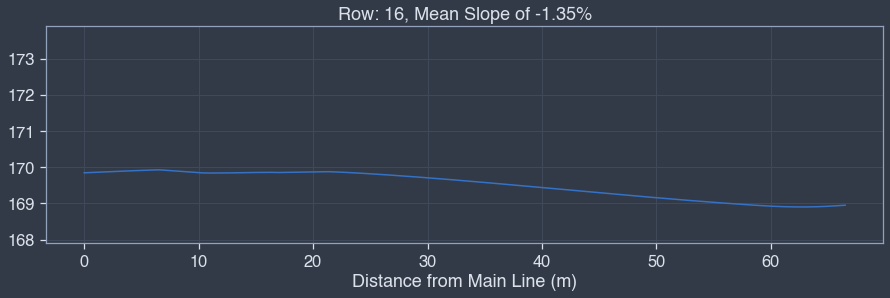

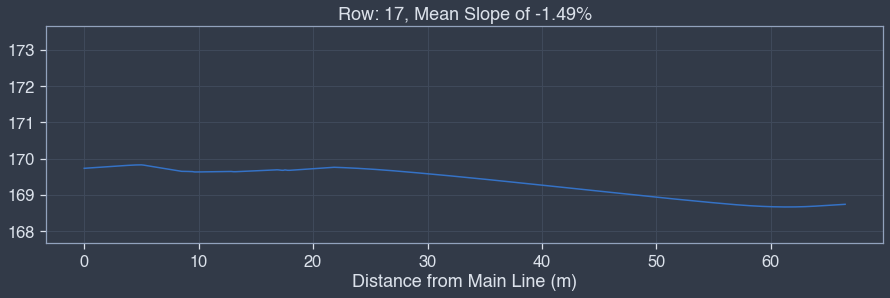

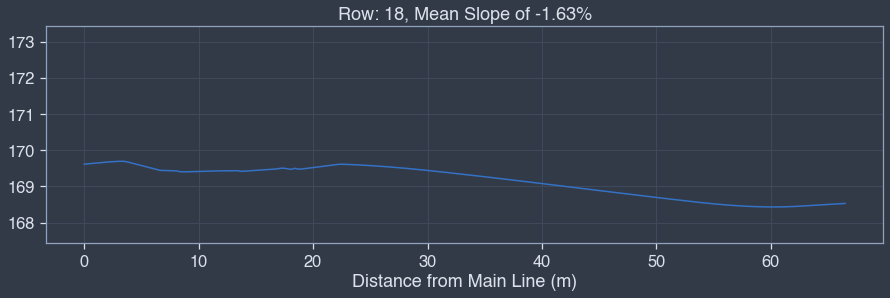

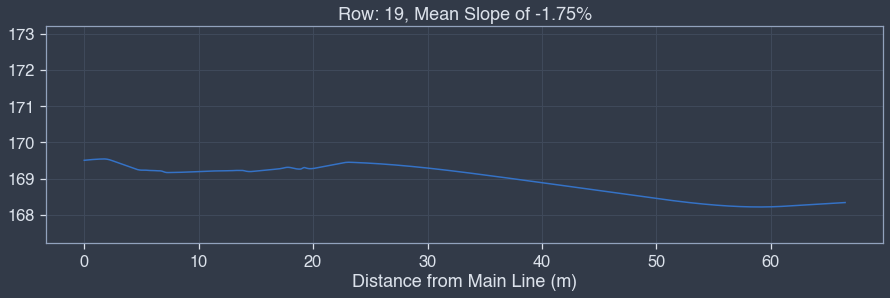

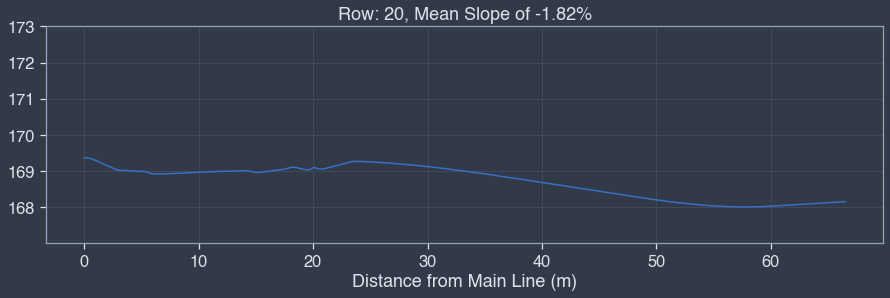

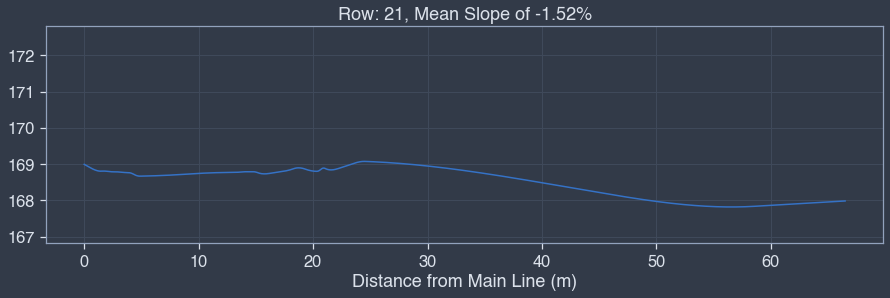

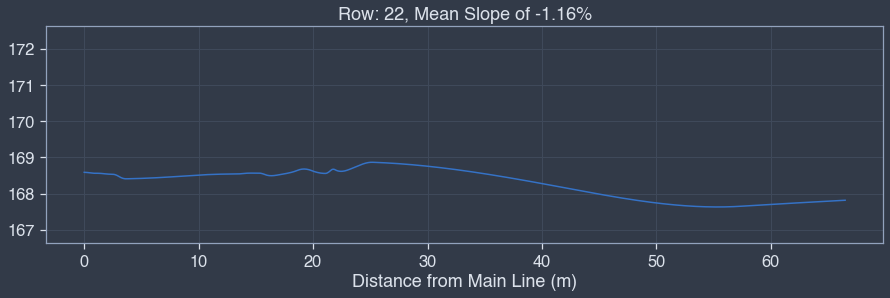

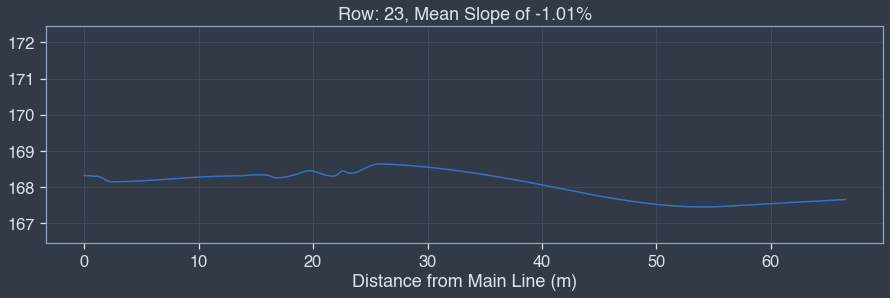

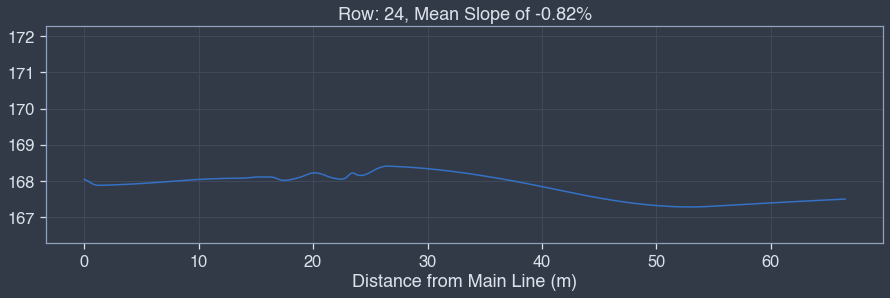

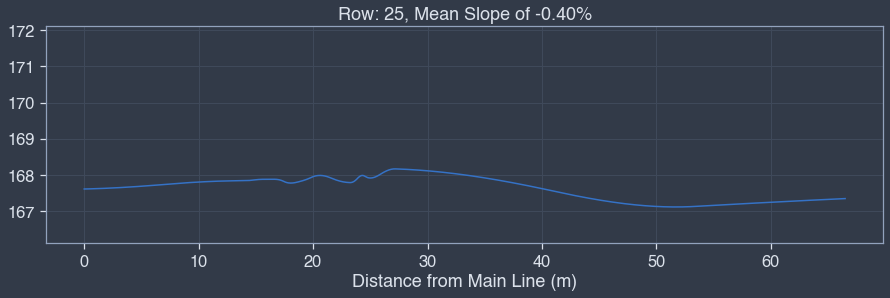

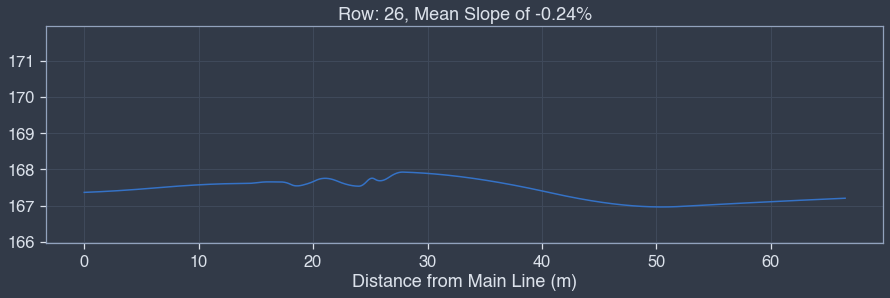

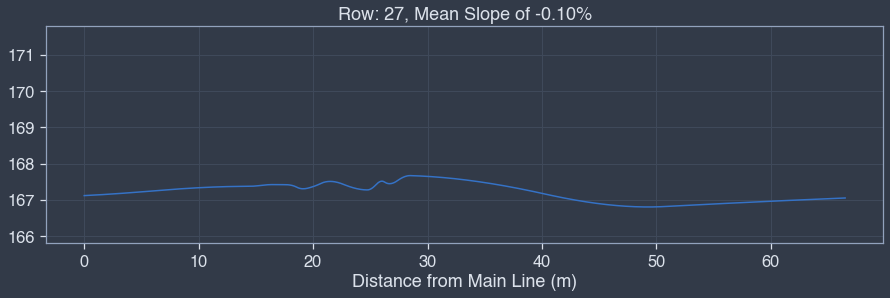

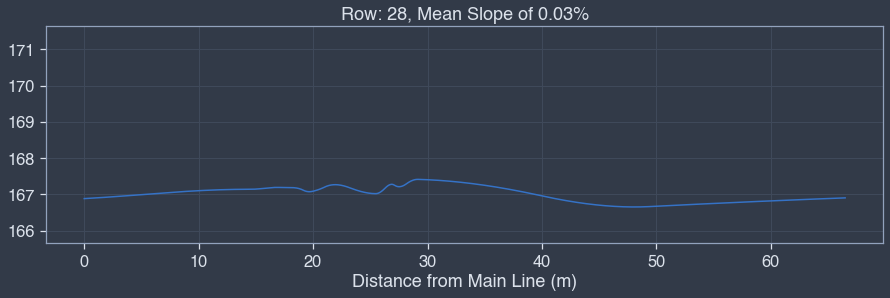

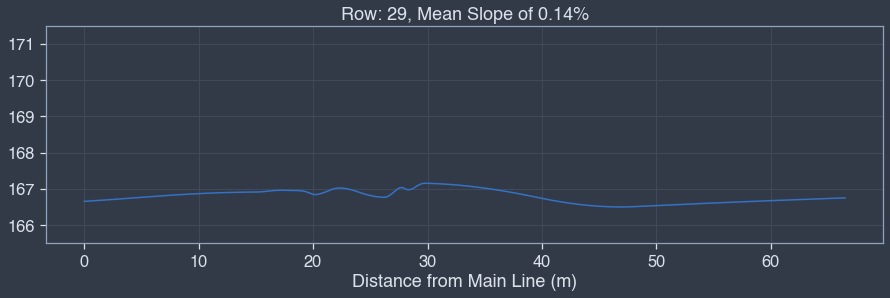

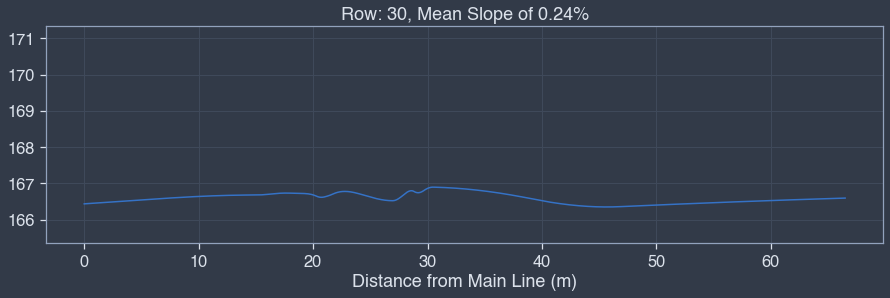

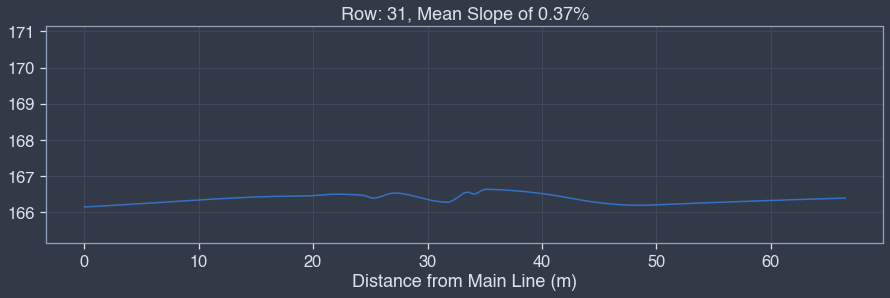

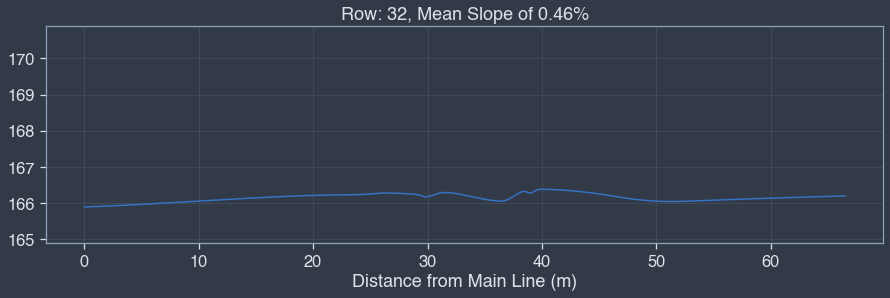

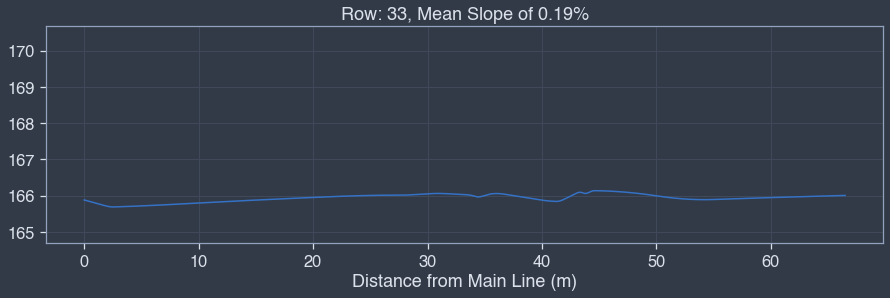

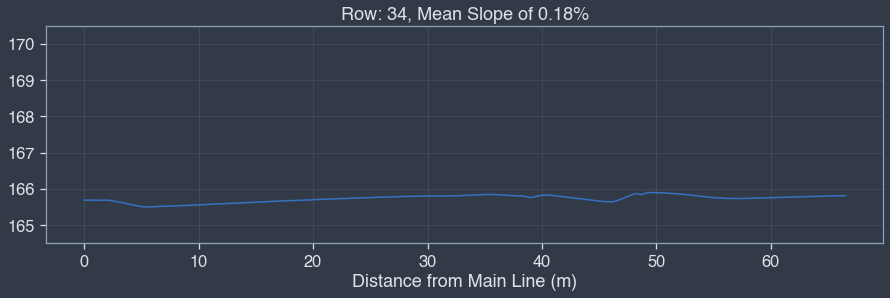

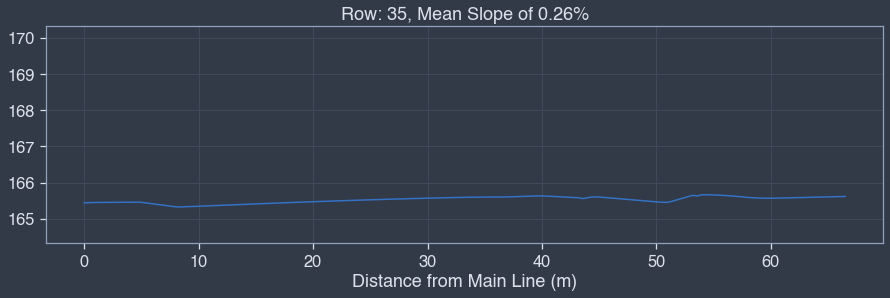

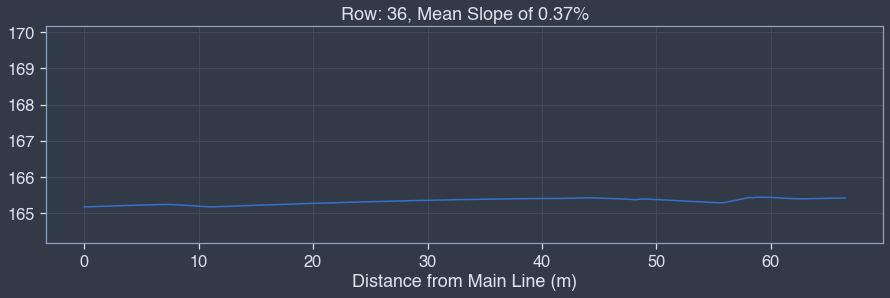

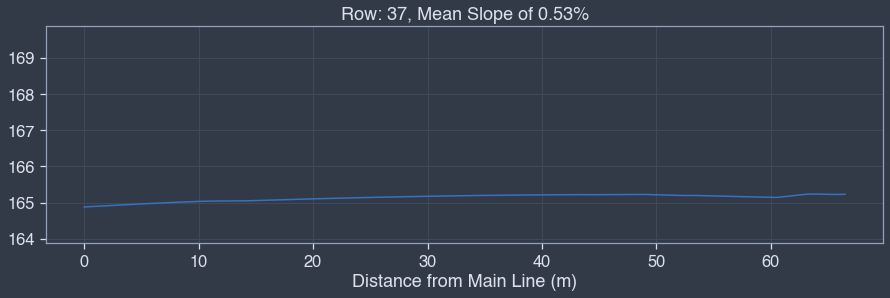

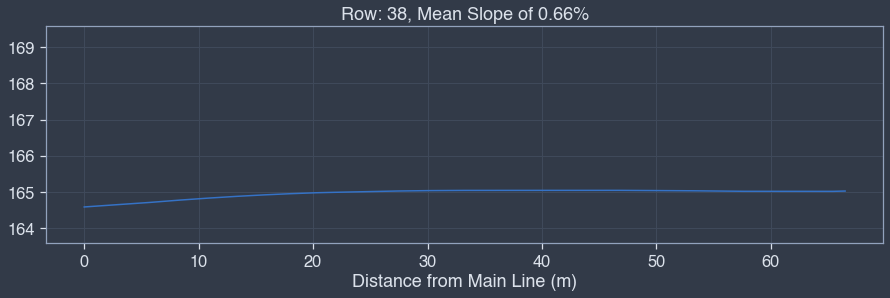

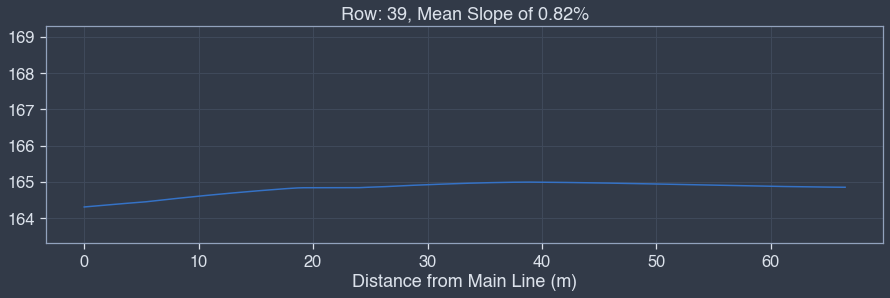

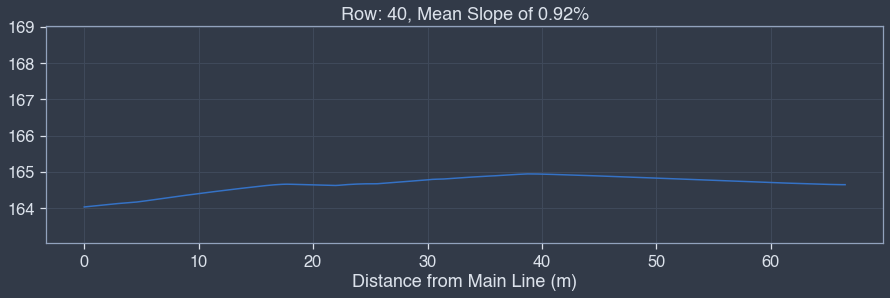

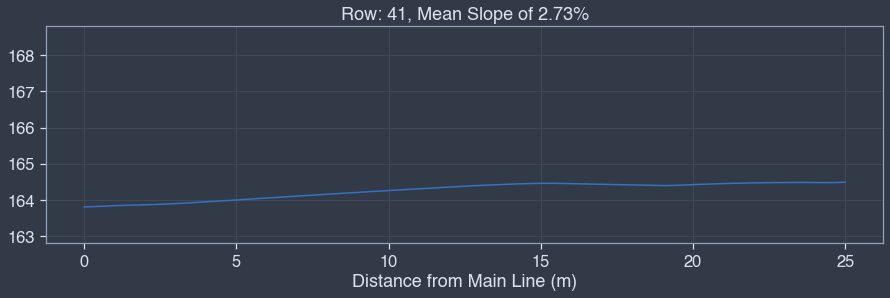

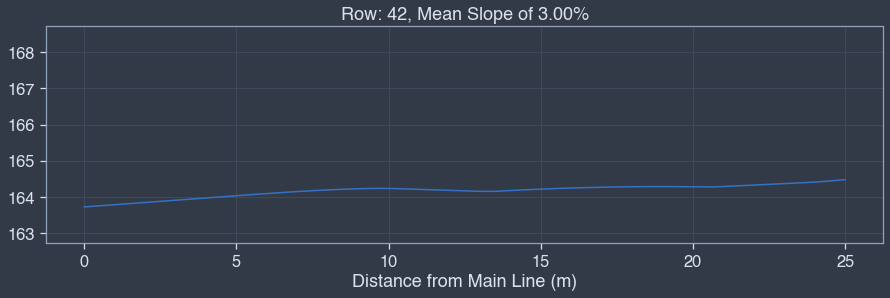

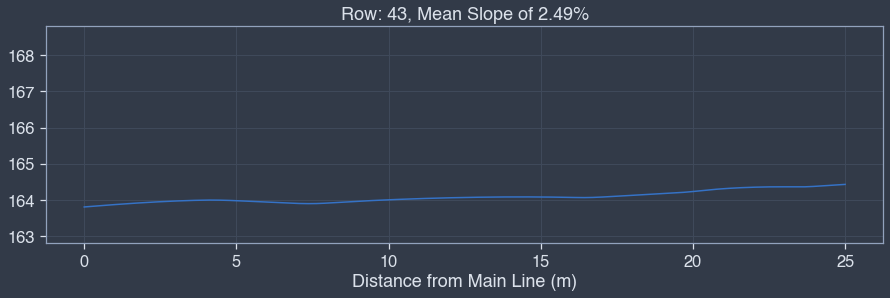

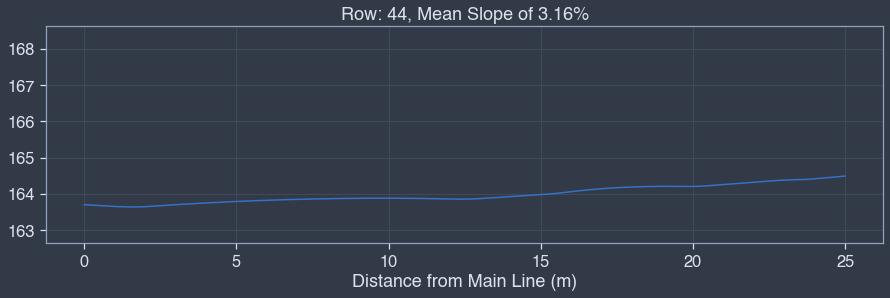

In [6]:
def plot_profile(line, r='?'):
    x_line = np.linspace(line[0,0],line[1,0],1000)
    y_line = np.linspace(line[0,1],line[1,1],1000)
    xy_line = np.c_[x_line, y_line]
    L = calculate_distance(line)
    x = np.linspace(0,L,1000) # The distance from main line
    altitude = fun.interpolate_altitude(xy_line).flatten()
    slope = (altitude[1:] - altitude[:-1]) / (x[1:] - x[:-1]) * 100 # [%]
    mean_slop = np.mean(slope) # [%]
    plt.plot(x,altitude )
    plt.title('Row: {}, Mean Slope of {:.2f}%'.format(r,mean_slop))
    plt.xlabel('Distance from Main Line (m)')
    plt.ylim(min(altitude)-1,5+min(altitude))
    
for line,r in zip(lines,range(0,len(lines))):
    line = line.reshape(2,2)
    plt.figure(figsize=(15,4))
    plot_profile(line,r+1)

# NOTE

For the next notebooks, we save this plotting code as a function in the file functions.py